# Activate Local Environment

In [1]:
] activate .

  Activating environment at `B:\Uni\Hauptstudium\DMML\Abgabe\Project.toml`


# Imports

In [2]:
using DataFrames
using CSV
using PandasHelpers
using Dates
using ShiftedArrays
using Statistics
using Plots

In [3]:
import Base.>
import Base.Bool

In [4]:
using Flux

# Hyperparameters and Function Definition

In [5]:
# hyperparameters
SHIFT = [1,2,3,5,10]
NUM_EPOCHS = 25
DECISION_BOUNDARY = 0.4

0.4

In [6]:
# define any number to be bigger than missing
(>)(a::Number, b::Missing)  = true
# define any real number but 0 to be true
Bool(a::Real) = a == 0 ? false : true

Bool

In [7]:
# split datetime into weekday, hour and minute
function split_dt(dt)
    [Dates.dayofweek(dt), Dates.hour(dt), Dates.minute(dt)]
end
# create new column whether there was a rise when compared to <shift> columns before
function didrise!(df::DataFrame, cols::Vector{String}, shift::Number)
    for col in cols
        df[:, "change_$(col)_$(shift)"] = BitArray(df[:, col] .> ShiftedArray(df[:, col], shift))
    end
end

didrise! (generic function with 1 method)

In [8]:
# Data Pipeline
function pipeline(raw::DataFrame, shifts)
    # create copy without index
    df = copy(raw[:, Not(:index)])
    # convert to DateTime round to the nearest minute
    select!(df, :Datum => ByRow(x->round(DateTime(x, "yyyy-mm-dd HH:MM:SS"), Dates.Minute)) => :Datum, :)
    # create columns for weekday, hour and minute, drop column Datum
    select!(df, :Datum => ByRow(x -> split_dt(x)) => [:Wochentag, :Stunde, :Minute] , Not(:Datum))
    # impute missing values
    naive_impute!(df.Temperatur)
    naive_impute!(df.Luftfeuchtigkeit)
    naive_impute!(df.CO2)
    # dummy encode weekday and hour
    get_dummies!(df, "Wochentag")
    get_dummies!(df, "Stunde")
    # create columns for relative change of temperature, humidity and co2
    for shift in shifts
        didrise!(df, ["Temperatur", "Luftfeuchtigkeit", "CO2", "Wassergehalt"], shift)
    end
    # abs max normalize 
    abs_max_norm!(df, names(df))
    return df
end

pipeline (generic function with 1 method)

In [9]:
# neccessary transformation for prediction
function predict(x, threshold)
    # transpose, shift by threshold and round
    round.(vec(model(transpose(Array(x)))) .+ (0.5-threshold))
end

predict (generic function with 1 method)

In [10]:
# count tp, fp, fn, tn and optionally display confusion matrix
function confusion_matrix(ŷ, y; draw=false)
    ŷ = Bool.(ŷ)
    y = Bool.(y)
    tp = fp = fn = tn = 0
    for (i,j) in zip(ŷ, y)
        if i & j
            tp += 1
        elseif i & !j
            fp +=1
        elseif !i & j
            fn += 1
        else
            tn += 1
        end
    end
    if draw
        display(["Confusion Matrix" "Y" "!Y" ; "Ŷ" tp fp; "!Ŷ" fn tn])
    end
    return [tp, fp, fn, tn]
end

confusion_matrix (generic function with 1 method)

In [11]:
# draw ROC curve
function draw_roc()
    thresholds = 0:0.01:1.01
    metrics = [confusion_matrix(predict(val_x, threshold), val_y, draw=false) for threshold in thresholds]
    tprs = [tp/(tp+fn) for (tp, fp, fn, tn) in metrics]
    fprs = [fp/(fp+tn) for (tp, fp, fn, tn) in metrics]
    plot(fprs, tprs, label="ROC")
    plot!([0,1],[0,1], label="Baseline")
end

draw_roc (generic function with 1 method)

# Preprocessing

In [12]:
# read raw data
raw = DataFrame(CSV.File("train.csv"))
# split into train and validation set
train_x, train_y, val_x, val_y = train_test_split(pipeline(raw, SHIFT), 0.9, "Anwesenheit")

(12817×56 DataFrame
   Row │ Minute     Temperatur  Luftfeuchtigkeit  CO2       Wassergehalt  Woch ⋯
       │ Float64    Float64     Float64           Float64   Float64       Floa ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ 0.118644     0.868556          0.75401   0.295046      0.709277       ⋯
     2 │ 0.949153     0.824855          0.81268   0.252075      0.715878
     3 │ 0.0338983    0.810789          0.485716  0.214937      0.417563
     4 │ 0.186441     0.807101          0.495686  0.217402      0.423788
     5 │ 0.440678     0.868556          0.672078  0.420754      0.631698       ⋯
     6 │ 0.322034     0.810789          0.488273  0.216909      0.41977
     7 │ 0.661017     0.894094          0.762404  0.346069      0.745349
     8 │ 0.372881     0.989416          0.580303  0.359502      0.652506
     9 │ 0.40678      0.973438          0.671311  0.38945       0.738005       ⋯
    10 │ 0.20339      0.925913          0.769477  0.59391

# Modelling

In [ ]:
# Baseline A, big network
model = Chain(
    Dense(size(train_x)[2], 64, relu),
    Dense(64,128, relu),
    Dense(128,256, relu),
    Dense(256,128, relu),
    Dense(128,64, relu),
    Dense(64, 1, sigmoid)
    )

In [ ]:
# Baseline B, semi big, with dropout
model = Chain(
    Dense(size(train_x)[2], 16, relu),
    Dropout(0.1),
    Dense(16,128, relu),
    Dropout(0.1),
    Dense(128,64, relu),
    Dropout(0.1),
    Dense(64,16, relu),
    Dropout(0.1),
    Dense(16, 1, sigmoid)
    )

In [13]:
# Baseline C, small network with dropout
model = Chain(
    Dense(size(train_x)[2], 64, relu),
    Dropout(0.2),
    Dense(64, 1, sigmoid)
    )

Chain(
  Dense(56, 64, relu),                  # 3_648 parameters
  Dropout(0.2),
  Dense(64, 1, σ),                      # 65 parameters
)                   # Total: 4 arrays, 3_713 parameters, 14.785 KiB.

In [14]:
# Optimizer
opt = ADAM(0.001, (0.9, 0.999))
# pointer to parameters
ps = Flux.params(model)
# loss function
loss((x,y)) = Flux.Losses.binarycrossentropy(transpose(model(x)), y)
# dataloader object
data = Flux.Data.DataLoader((data=transpose(Array(train_x)), label=train_y), batchsize=100,shuffle=true)

Flux.Data.DataLoader{NamedTuple{(:data, :label), Tuple{LinearAlgebra.Transpose{Float64, Matrix{Float64}}, Vector{Float64}}}, Random._GLOBAL_RNG}((data = [0.11864406779661017 0.9491525423728814 … 0.6440677966101694 0.6440677966101694; 0.8685558210993525 0.8248548992830316 … 0.8665073403892125 0.8398770911573927; … ; 1.0 1.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0], label = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]), 100, 12817, true, 12817, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817], true, Random._GLOBAL_RNG())

In [15]:
# training loop
for epoch in 1:NUM_EPOCHS
    Flux.train!(loss, ps, data, opt)
    if epoch % 5 == 0
        ŷ = predict(train_x, DECISION_BOUNDARY)
        (tp, fp, fn, tn) = confusion_matrix(ŷ, train_y)
        acc = round((tp+tn) / (tp+fp+fn+tn), digits=4)
        ŷ = predict(val_x, DECISION_BOUNDARY)
        (tp, fp, fn, tn) = confusion_matrix(ŷ, val_y)
        val_acc = round((tp+tn) / (tp+fp+fn+tn), digits=4)
        println("Epoch: $(epoch) Accuracy: $(acc) Val-Accuracy: $(val_acc)")
    end
end

Epoch: 5 Accuracy: 0.9585 Val-Accuracy: 0.9565
Epoch: 10 Accuracy: 0.9645 Val-Accuracy: 0.9586
Epoch: 15 Accuracy: 0.9722 Val-Accuracy: 0.967
Epoch: 20 Accuracy: 0.9767 Val-Accuracy: 0.9733
Epoch: 25 Accuracy: 0.9769 Val-Accuracy: 0.974


# Evaluation

In [16]:
(tp, fp, fn, tn) = confusion_matrix(predict(val_x, 0.6), val_y, draw=true)

3×3 Matrix{Any}:
 "Confusion Matrix"     "Y"      "!Y"
 "Ŷ"                332       19
 "!Ŷ"                21     1052

4-element Vector{Int64}:
  332
   19
   21
 1052

In [17]:
# recall
tp / (fn + tp)

0.9405099150141643

In [18]:
# precision
tp / (tp+fp)

0.9458689458689459

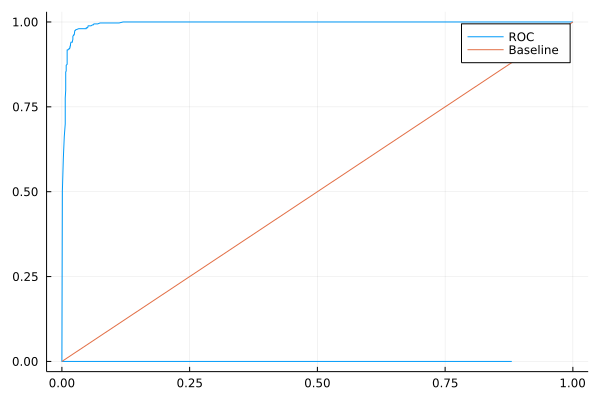

In [19]:
draw_roc()

# Prediction

In [20]:
test_raw = DataFrame(CSV.File("test.csv"))

,index,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt
,Int64,String31,Float64?,Float64?,Float64?,Float64
1,3434,2017-02-04 00:01:00,20.05,33.545,507.0,0.00486861
2,3435,2017-02-04 00:02:00,20.0333,33.6267,505.333,0.00487548
3,3436,2017-02-04 00:03:00,20.0,33.59,505.5,0.00486
4,3437,2017-02-04 00:04:00,20.0,33.645,504.5,0.00486802
5,3438,2017-02-04 00:04:59,20.0,33.6267,504.667,0.00486535
6,3439,2017-02-04 00:06:00,20.0,33.645,507.5,0.00486802
7,3440,2017-02-04 00:07:00,20.0,33.7,509.0,0.00487604
8,3441,2017-02-04 00:08:00,20.0,33.59,511.0,0.00486
9,3442,2017-02-04 00:08:59,20.0333,33.6267,506.667,0.00487548


In [21]:
# transform and join with empty copy of train_x to mimic feature order
test = vcat(similar(train_x,0), pipeline(test_raw, SHIFT), cols=:union)
# fill missing values
replace!.(eachcol(test), missing=>0)
test

,Minute,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Wochentag_3,Wochentag_4
,Float64,Float64,Float64,Float64,Float64,Float64,Float64?
1,0.0169492,0.860884,0.849241,0.244161,0.843983,0.0,0.0
2,0.0338983,0.860169,0.851308,0.243358,0.845175,0.0,0.0
3,0.0508475,0.858738,0.85038,0.243438,0.842491,0.0,0.0
4,0.0677966,0.858738,0.851772,0.242957,0.843881,0.0,0.0
5,0.0847458,0.858738,0.851308,0.243037,0.843418,0.0,0.0
6,0.101695,0.858738,0.851772,0.244402,0.843881,0.0,0.0
7,0.118644,0.858738,0.853165,0.245124,0.845272,0.0,0.0
8,0.135593,0.858738,0.85038,0.246087,0.842491,0.0,0.0
9,0.152542,0.860169,0.851308,0.244,0.845175,0.0,0.0


In [22]:
test_raw[!, "Anwesenheit"] = predict(test, 0.6)

6319-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [ ]:
# write to disk
CSV.write("nn_output.csv", test_raw)

In [23]:
# split date
select!(test_raw, :Datum => ByRow(x->round(DateTime(x, "yyyy-mm-dd HH:MM:SS"), Dates.Minute)) => :Datum, :)
select!(test_raw, :Datum => ByRow(x -> split_dt(x)) => [:Wochentag, :Stunde, :Minute] , Not(:Datum))
# display grouped by weekday
gdf = groupby(test_raw, [:Stunde])
combine(gdf, :Anwesenheit => sum)[:, :]

,Stunde,Anwesenheit_sum
,Int64,Float64
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
5,4,0.0
6,5,0.0
7,6,0.0
8,7,29.0
9,8,108.0
